In [4]:
from my_functions import*

In [5]:
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

In [6]:
nmin1=0
nmax1=100

nmin2=0
nmax2=3000
dr_min=0.0
dr_max=0.4


Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected


Computing ROC curve: 100%|██████████| 6/6 [01:03<00:00, 10.55s/it]


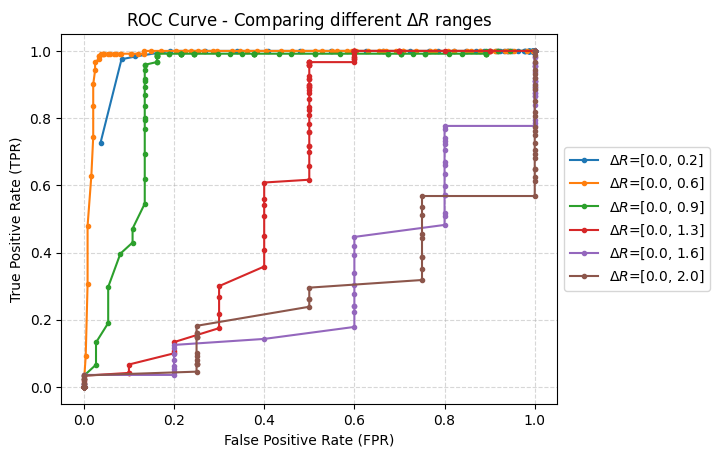

<Figure size 800x600 with 0 Axes>

In [7]:
dr_min = np.linspace(0, 0, 3)
dr_max = np.linspace(0.2, 2, 3)
bins = np.linspace(0, 5, 120)

plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, [0,50],[1000,2000],bins,dr_min,dr_max)

Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected


Computing ROC curve: 100%|██████████| 5/5 [02:46<00:00, 33.23s/it]


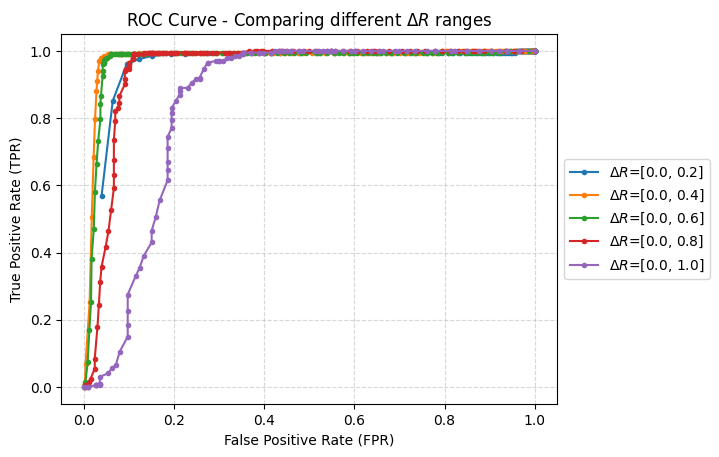

<Figure size 1200x600 with 0 Axes>

In [7]:
dr_min = np.linspace(0, 0, 3)
dr_max = np.linspace(0.2, 1, 3)
bins = np.linspace(0, 5, 120)

plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, [0,100],[1000,3000],bins,dr_min,dr_max)

Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected


Computing ROC curve: 100%|██████████| 5/5 [02:41<00:00, 32.26s/it]


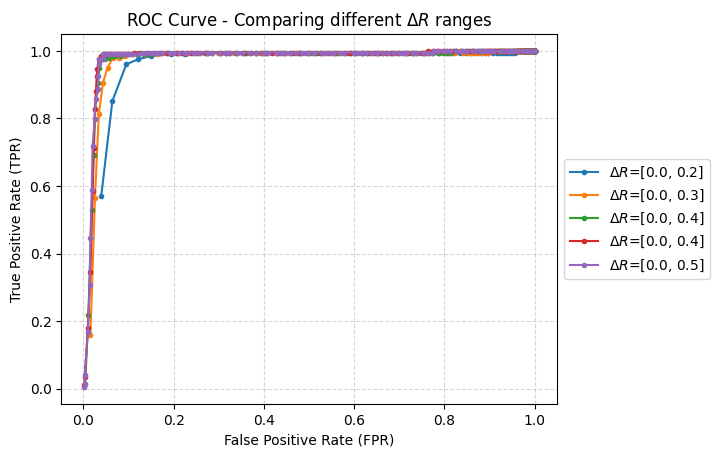

<Figure size 1200x600 with 0 Axes>

In [8]:
dr_min = np.linspace(0, 0, 3)
dr_max = np.linspace(0.2, 0.5, 3)
bins = np.linspace(0, 5, 120)

plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, [0,100],[1000,3000],bins,dr_min,dr_max)

Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected


Computing ROC curve: 100%|██████████| 3/3 [01:36<00:00, 32.32s/it]


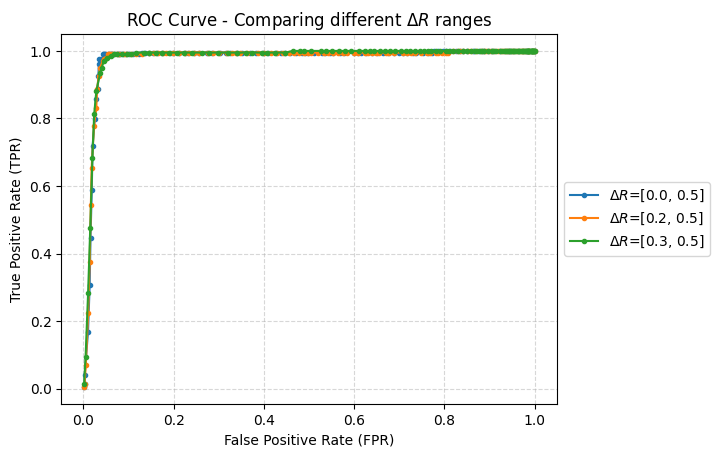

<Figure size 1200x600 with 0 Axes>

In [9]:
dr_min = np.linspace(0, 0.3, 3)
dr_max = np.linspace(0.5, 0.5, 3)
bins = np.linspace(0, 5, 120)

plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, [0,100],[1000,3000],bins,dr_min,dr_max)